In [3]:
# standard imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import spotpy

In [4]:
# custom imports
import model.camels_utilities as camels
from model.sacsma_utilities import run_sacsma, rmse_obj_fun
from optimizer.optimizer import spotpy_setup

In [5]:
# # this command is executed twice for interactive plotting in Jupyter notebook
# %matplotlib notebook
# %matplotlib notebook

In [6]:
basin = '01054200'

# Load data
parameters = camels.load_sacsma_parameters(basin)
attributes = camels.load_basin_attributes(basin)
forcings, area = camels.load_forcings(basin)
observations = camels.load_usgs(basin, area)
benchmarks = camels.load_discharge(basin)

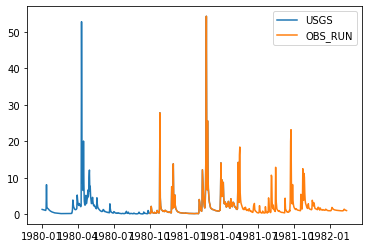

In [7]:
fig = plt.figure()
plt.plot(observations.QObs.iloc[:500], label='USGS')
plt.plot(benchmarks.OBS_RUN.iloc[:500], label='OBS_RUN')
plt.legend()
plt.show()

In [8]:
sac_fluxes, sac_states = run_sacsma(forcings=forcings,
                                    parameters=parameters,
                                    latitude=attributes['gauge_lat'],
                                    elevation=attributes['elev_mean'])

sac_fluxes

,sacsma_pet,sacsma_snow17_raim,sacsma_uh_qq,sacsma_snow17_sneqv,sacsma_snow17_snow,sacsma_snow17_snowh,sacsma_surf,sacsma_grnd,sacsma_qq,sacsma_tet
Date,,,,,,,,,,
1980-01-01,-0.028142,0.000000,231.641983,0.000000,0.0,0.000000,212.029297,19.612690,231.641983,-0.080839
1980-01-02,-0.030082,0.000000,131.199997,0.000000,0.0,0.000000,112.222473,18.977518,131.199997,-0.029931
1980-01-03,-0.013118,0.009180,50.367165,0.000000,0.0,0.000000,32.321926,18.045237,50.367165,-0.013053
1980-01-04,0.003370,0.018360,26.357958,0.000000,0.0,0.000000,9.278200,17.079758,26.357958,0.003353
1980-01-05,0.015235,0.000000,18.775337,0.000000,0.0,0.000000,2.631555,16.143782,18.775337,0.015159
...,...,...,...,...,...,...,...,...,...,...
2014-12-27,-0.069802,0.083459,5.996112,0.015817,0.0,0.048491,3.409278,2.586834,5.996112,-0.069453
2014-12-28,0.020029,16.967937,7.700307,0.012859,0.0,0.036643,5.131092,2.569216,7.700307,0.019929
2014-12-29,-0.024321,0.815457,7.709418,0.012044,0.0,0.036131,5.092212,2.617206,7.709418,-0.024199


In [ ]:
# df = pd.concat((sac_fluxes, observations))
df = sac_fluxes['sacsma_uh_qq'].to_frame()
df = df.join(observations['QObs'])
df = df.join(benchmarks.MOD_RUN)
df = df.dropna(axis=0, how='any')
rmse = np.sqrt(np.mean((df.sacsma_uh_qq - df.QObs)**2))
rmse

In [ ]:
ours_rmse = np.sqrt(np.mean((df.sacsma_uh_qq - observations['QObs'])**2))
ncar_rmse = np.sqrt(np.mean((df.MOD_RUN - observations['QObs'])**2))

print(ours_rmse, ncar_rmse)

In [ ]:
fig = plt.figure()
plt.plot(df['sacsma_uh_qq'], label='sacsma_uh_qq')
plt.plot(df['MOD_RUN'], label='MOD_RUN')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(df['QObs'], label='Observations')
plt.plot(df['MOD_RUN'], label='OBS_RUN')
plt.legend()
plt.show()

In [ ]:
rmse = rmse_obj_fun(forcings=forcings,
                    parameters=parameters,
                    observations=observations['QObs'],
                    latitude=attributes['gauge_lat'],
                    elevation=attributes['elev_mean'])

rmse

In [ ]:
optimizer = spotpy_setup(forcings=forcings,
                         observations=observations['QObs'],
                         latitude=attributes['gauge_lat'],
                         elevation=attributes['elev_mean'],
                         warmup=365)

In [ ]:
parms = parameters
parm_vector = parms.loc[optimizer.optimized_parameter_names].values
sim = optimizer.simulation(parm_vector)

In [ ]:
rmse = optimizer.objectivefunction(sim, optimizer.evaluation())
rmse

In [ ]:
sim_df = pd.DataFrame(sim, index=forcings.iloc[365*2:].index)
fig = plt.figure()
plt.plot(sac_fluxes.sacsma_uh_qq, label='sacsma_uh_qq')
plt.plot(benchmarks.MOD_RUN, label='MOD_RUN')
plt.plot(sim_df, label='spotpy')
plt.legend()
plt.show()


In [ ]:
fig = plt.figure()
plt.scatter(sim_df,sac_fluxes.sacsma_uh_qq, label='sacsma_uh_qq')
# plt.plot(benchmarks.MOD_RUN, label='MOD_RUN')
# plt.plot(sim_df, label='spotpy')
plt.legend()
plt.show()


In [ ]:
sampler=spotpy.algorithms.sceua(optimizer, 
                                dbname='SCE', 
                                dbformat='csv')
max_model_runs = 1e5
sampler.sample(max_model_runs, ngs=20)

In [ ]:
results = sampler.getdata()
